This jupyter notebook is used to analyze the isotype-sensitive residues.

In [13]:
import pandas as pd
import numpy as np
import re

import math
import scipy.stats as stat


import seaborn as sns
from matplotlib import pyplot as plt
from adjustText import adjust_text

from Bio.SeqUtils import seq1
from Bio.PDB import PDBParser, PDBIO

import py3Dmol


In [3]:
vcab_dir = "final_vcab.csv"
vcab=pd.read_csv(vcab_dir).drop(columns=["Unnamed: 0"])

In [5]:
vcab.columns

Index(['pdb', 'Hchain', 'Lchain', 'vh_species_hmm', 'heavy_vfamily',
       'vl_species_hmm', 'light_vfamily', 'H_seq', 'L_seq', 'H_coordinate_seq',
       'L_coordinate_seq', 'VHseq_IMGT_numbering', 'VLseq_IMGT_numbering',
       'H_PDB_numbering', 'L_PDB_numbering', 'iden_code', 'title',
       'release_date', 'method', 'resolution', 'carbohydrate', 'H_pdb_species',
       'L_pdb_species', 'antigen_chain', 'antigen_type', 'antigen_description',
       'VH_species', 'VL_species', 'HC_species', 'LC_species', 'VH_allele',
       'VL_allele', 'Htype', 'Ltype', 'Alternative_VH_allele',
       'Alternative_VL_allele', 'Alternative_Htype', 'Alternative_Ltype',
       'H_seq_VC_boundary', 'L_seq_VC_boundary', 'align_info', 'Domains in HC',
       'Structural Coverage', 'H_coordinate_seq_VC_boundary',
       'L_coordinate_seq_VC_boundary', 'pdb_H_VC_Boundary',
       'pdb_L_VC_Boundary', 'HC_coordinate_seq', 'LC_coordinate_seq', 'HV_seq',
       'HC_seq', 'LV_seq', 'LC_seq', 'disulfide_bond',

### List the information of these antibodies: 3qnx, 3qo1, 3qo0. They have the same light chain and same VH domain. The only thing that is different is their isotype.

In [7]:
vcab.loc[vcab["pdb"].isin(["3qnx","3qo1","3qo0"]),["iden_code","Htype","Ltype","HV_seq","LV_seq"]]

,iden_code,Htype,Ltype,HV_seq,LV_seq
1168,3qnx_BA,"IgA1(homo_sapiens|IGHA1*01,IGHA1*03: Per.Ident...",kappa(homo_sapiens|IGKC*01: Per.Ident: 100.0),EVQLVESGGGLVQPGGSLKLSCAASGFTLSGSNVHWVRQASGKGLE...,DIVMTQSPLSLSVTPGEPASISCRSSQSLLRRDGHNDLEWYLQKPG...
1172,3qo0_BA,"IgG1(homo_sapiens|IGHG1*03,IGHG1*06: Per.Ident...",kappa(homo_sapiens|IGKC*01: Per.Ident: 100.0),EVQLVESGGGLVQPGGSLKLSCAASGFTLSGSNVHWVRQASGKGLE...,DIVMTQSPLSLSVTPGEPASISCRSSQSLLRRDGHNDLEWYLQKPG...
1173,3qo1_BA,"IgG1(homo_sapiens|IGHG1*03,IGHG1*06: Per.Ident...",kappa(homo_sapiens|IGKC*01: Per.Ident: 100.0),EVQLVESGGGLVQPGGSLKLSCAASGFTLSGSNVHWVRQASGKGLE...,DIVMTQSPLSLSVTPGEPASISCRSSQSLLRRDGHNDLEWYLQKPG...


# Compare the mutational scanning scores of HV residues in different antibodies

In [8]:
def get_score_comparison(ab1_fn,ab2_fn,score_col="normalized_score"):
    """ 
    This function takes in two antibody mutation files and returns a dataframe with the mutations and the scores of the two antibodies.
    args:input:
    ab1_fn: str, file path to the first antibody mutation file
    ab2_fn: str, file path to the second antibody mutation file
    score_col: str, column name of the score in the mutation scanning file
    
    returns:
    comp_abs: pd.DataFrame, a dataframe with the mutations and the scores of the two antibodies.
    """
    ab1=pd.read_csv(ab1_fn).drop(columns=["Unnamed: 0"])
    ab2=pd.read_csv(ab2_fn).drop(columns=["Unnamed: 0"])
    ab1_v=ab1.loc[ab1["VorC"]=="V"]
    ab2_v=ab2.loc[ab2["VorC"]=="V"]
    ab1_v=ab1_v.sort_values("pdb_numbering")
    ab2_v=ab2_v.sort_values("pdb_numbering")
    
    ab1_v=ab1_v.loc[:,["mutation",score_col]]
    ab2_v=ab2_v.loc[:,["mutation",score_col]]
    
    comp_abs=ab1_v.merge(ab2_v,on="mutation",suffixes=("_"+ab1_fn.split("_rosetta_pmut_info.csv")[0],"_"+ab2_fn.split("_rosetta_pmut_info.csv")[0]))
    
    return comp_abs

In [9]:
# Get the comparison of the scores of the two antibodies of different isotypes, and two of the same isotypes
iso_diff_comp=get_score_comparison("3qnx_BA_rosetta_pmut_info.csv","3qo0_BA_rosetta_pmut_info.csv")
iso_same_comp=get_score_comparison("3qo1_BA_rosetta_pmut_info.csv","3qo0_BA_rosetta_pmut_info.csv")

<AxesSubplot:xlabel='normalized_score_3qo0_BA', ylabel='normalized_score_3qo1_BA'>

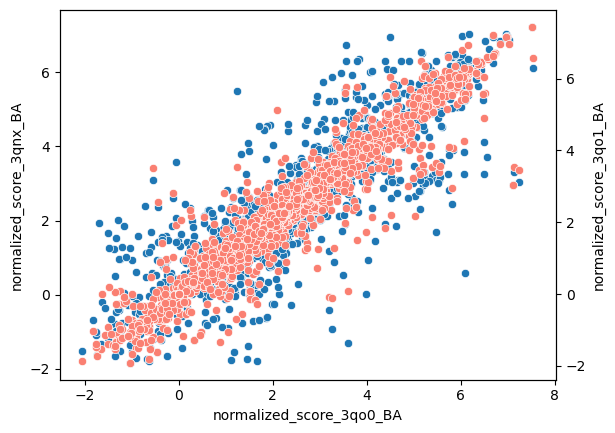

In [10]:
fig, ax = plt.subplots()
sns.scatterplot(data=iso_diff_comp,x="normalized_score_3qo0_BA",y="normalized_score_3qnx_BA",ax=ax)
ax2=ax.twinx()
sns.scatterplot(data=iso_same_comp,x="normalized_score_3qo0_BA",y="normalized_score_3qo1_BA",ax=ax2,color="salmon")
#plt.savefig("3qo0_3qnx_3qo1_score_comparison.pdf")

# Volcano plot for isotype sensitivity

In [11]:
# Collect the information of iso_diff_comp and iso_same_comp
comp=iso_diff_comp.merge(iso_same_comp,on="mutation").drop(columns=["normalized_score_3qo0_BA_x"]).rename(columns={"normalized_score_3qo0_BA_y":"normalized_score_3qo0_BA"})

comp["WT"]=comp["mutation"].str[0:-1]
comp["MUT_aa"]=comp["mutation"].str[-1]

comp["diff_3qnx_3qo0"]=comp["normalized_score_3qnx_BA"]-comp["normalized_score_3qo0_BA"]
comp["diff_3qo1_3qo0"]=comp["normalized_score_3qo1_BA"]-comp["normalized_score_3qo0_BA"]
comp

,mutation,normalized_score_3qnx_BA,normalized_score_3qo1_BA,normalized_score_3qo0_BA,WT,MUT_aa,diff_3qnx_3qo0,diff_3qo1_3qo0
0,Q3C,1.593943,1.376179,1.525182,Q3,C,0.068761,-0.149004
1,Q3Y,1.695879,1.652492,1.753498,Q3,Y,-0.057619,-0.101006
2,Q3F,1.832581,1.796527,2.091457,Q3,F,-0.258876,-0.294930
3,Q3V,2.261409,2.052837,1.581465,Q3,V,0.679944,0.471372
4,Q3L,1.415559,0.593871,0.740924,Q3,L,0.674635,-0.147053
...,...,...,...,...,...,...,...,...
2218,S119V,2.171160,1.705772,1.751815,S119,V,0.419344,-0.046044
2219,S119W,1.791803,1.526345,1.452988,S119,W,0.338815,0.073357
2220,S119Y,1.729352,1.032512,0.727036,S119,Y,1.002316,0.305476
2221,S119Q,1.186414,0.828655,0.785345,S119,Q,0.401069,0.043310


In [12]:
# Calculate the p-value for each position, so later we can use the p_value to generate the volcano plot
comp_analysis=comp.groupby("WT").agg({"diff_3qnx_3qo0":"mean","diff_3qo1_3qo0":"mean"}).reset_index().rename(columns={"diff_3qnx_3qo0":"mean_diff_3qnx_3qo0","diff_3qo1_3qo0":"mean_diff_3qo1_3qo0"})
comp_analysis["pvalue"]=comp_analysis.apply(lambda x: stat.ttest_rel(comp.loc[comp["WT"]==x["WT"],"diff_3qnx_3qo0"],comp.loc[comp["WT"]==x["WT"],"diff_3qo1_3qo0"])[1],axis=1)
comp_analysis

,WT,mean_diff_3qnx_3qo0,mean_diff_3qo1_3qo0,pvalue
0,A23,0.950626,-0.103557,0.000042
1,A24,0.516171,0.184533,0.000177
2,A40,0.194183,-0.885725,0.002228
3,A55,-0.073858,-0.016293,0.011857
4,A59,-0.389822,-0.012461,0.003174
...,...,...,...,...
112,W47,-0.191696,0.050267,0.001008
113,Y105,-0.608516,-0.091655,0.172312
114,Y62,0.055404,-0.028158,0.001234
115,Y96,0.248082,0.203851,0.261602


In [32]:
def plt_volcano_plot(df):
    df=df.copy()
    df=df.loc[df["pvalue"]>0]
    df["-log10(p_value)"]=df["pvalue"].apply(lambda x: -math.log10(x))
    
    df["FC"]=df.apply(lambda x: (x["mean_diff_3qnx_3qo0"]-x["mean_diff_3qo1_3qo0"])/np.abs(x["mean_diff_3qo1_3qo0"]),axis=1)
    df["arcsinh_FC"]=df.apply(lambda x: np.arcsinh(x["FC"]),axis=1)
    
    plt.figure(figsize=(3,3), dpi=300)
    
    plt.scatter(x=df["arcsinh_FC"],y=df["-log10(p_value)"],s=7,label="Not significant",color="grey")

    # highlight down- or up- regulated genes
    down = df[(df["FC"]<=-2)&(df["pvalue"]<=0.01)]
    up = df[(df["FC"]>=2)&(df["pvalue"]<=0.01)]
    
    plt.axhline(y=-math.log10(0.01),color="grey",linestyle="--")
    plt.axvline(x=np.arcsinh(-2),color="grey",linestyle="--")
    plt.axvline(x=np.arcsinh(2),color="grey",linestyle="--")
    
    
    plt.scatter(x=down["arcsinh_FC"],y=down["-log10(p_value)"],s=8,label="Down",color="blue")
    plt.scatter(x=up["arcsinh_FC"],y=up["-log10(p_value)"],s=8,label="Up",color="red")
    

    # Uncomment the following lines to add the residue positions to the plot
    #texts=[]
    #for i,r in up.iterrows():
    #    texts.append(plt.text(x=r["arcsinh_FC"],y=r["-log10(p_value)"],s=up.loc[i,"WT"],fontsize=10))
    #for i,r in down.iterrows():
        #texts.append(plt.text(x=r["arcsinh_FC"],y=r["-log10(p_value)"],s=down.loc[i,"WT"],fontsize=10))
    #adjust_text(texts,arrowprops=dict(arrowstyle="-", color='black', lw=0.8)) #

    plt.xlabel("arcsinh(FC)")
    plt.ylabel("-log(p)")
    #plt.savefig("volcano_igg1_iga1_compare_without_text.pdf",dpi=300)
    plt.show()
    return (up,down)

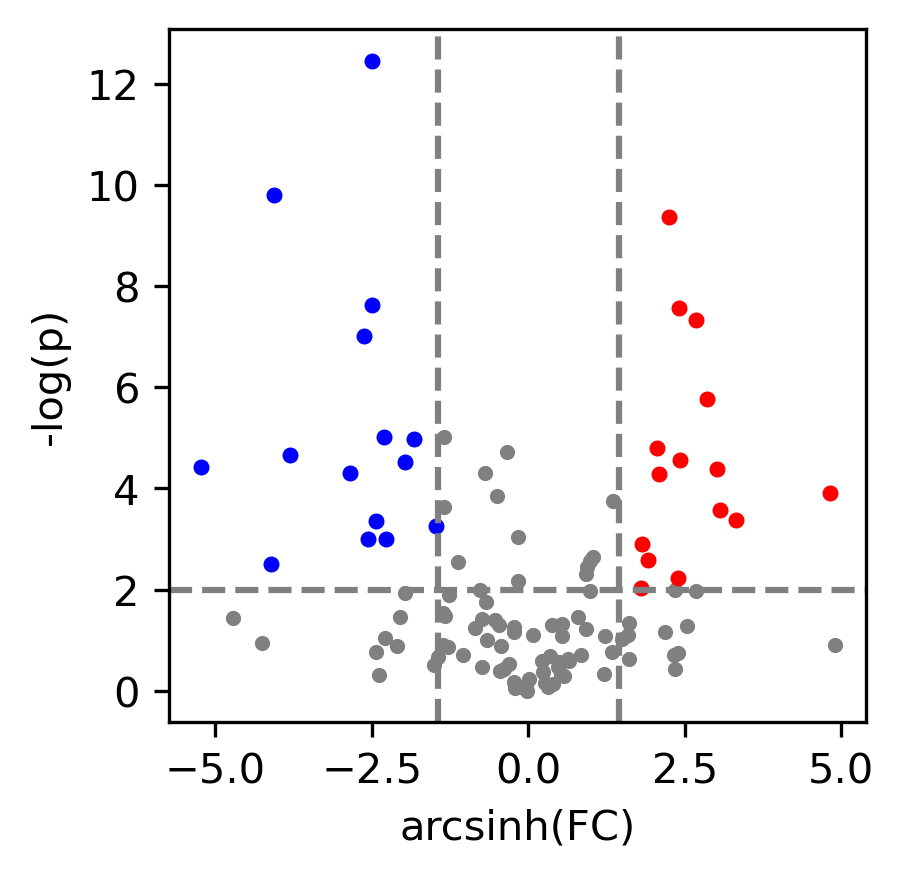

In [34]:
up,down=plt_volcano_plot(comp_analysis)

In [35]:
up # The highlighted red residues in the volcano plot

,WT,mean_diff_3qnx_3qo0,mean_diff_3qo1_3qo0,pvalue,-log10(p_value),FC,arcsinh_FC
0,A23,0.950626,-0.103557,4.198954e-05,4.376859,10.179723,3.015949
7,A64,0.592568,-0.061603,2.693224e-04,3.569728,10.619083,3.058010
12,D103,1.114033,-0.146644,1.693408e-06,5.771238,8.596872,2.847911
25,G110,0.275949,-0.119069,2.607576e-03,2.583763,3.317547,1.914350
27,G15,0.147719,-0.023504,4.586093e-08,7.338557,7.284864,2.683624
31,G42,0.148680,-0.033240,2.662455e-08,7.574718,5.472913,2.401202
36,G9,1.958930,0.343045,4.294250e-10,9.367113,4.710424,2.254007
65,Q108,1.096073,0.017365,1.236970e-04,3.907641,62.119635,4.822274
70,Q84,0.580687,-0.205436,1.559118e-05,4.807121,3.826604,2.051777
75,R53,0.225483,-0.050745,5.766420e-03,2.239094,5.443417,2.395886


# Map the highlighted residues in the volcano plot onto the antibody structure

In [74]:
# Write the function to color specific residues(indicated in the "WT" column in a dataframe) in pdb file
def color_specific_residues(pdb_file, output_file,chainid,up_df,down_df,col="WT"):
    """ 
    This function takes in a PDB file and a dataframe with the residues to be colored, and outputs a PDB file with b-factor changed, so that it will be colored in pymol lator.
    args:input:
    pdb_file: str, file path and name to the input PDB file
    output_file: str, file path and name to the output PDB file
    chainid: str, the chain id of the residues to be colored
    up_df: pd.DataFrame, a dataframe with the residues to be colored in red
    down_df: pd.DataFrame, a dataframe with the residues to be colored in blue
    col: str, the column name of the residue in the input dataframe
    """
    # Create a PDB parser
    parser = PDBParser()

    # Parse the PDB file
    structure = parser.get_structure("structure", pdb_file)

    # Iterate over all atoms in the structure
    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    atom.set_bfactor(0)
            
            if chain.get_id()!=chainid:
                continue
            for residue in chain:
                if residue.get_id()[0]!=" ":
                    continue
                # Get the residue name and residue position
                residue_name = seq1(residue.get_resname())
                residue_position = residue.get_id()[1]
                residue_id=f"{residue_name}{residue_position}"
                # Assign color to the residue
                
                # Set b-factor for each residue to the specified value
                if residue_id in up_df[col].values:
                    bfactor_value = 2.715
                elif residue_id in down_df[col].values:
                    bfactor_value = -2.715
                else:
                    bfactor_value=0
                #print(residue_id,bfactor_value)
                for atom in residue:
                    #print(atom.get_bfactor())
                    atom.set_bfactor(bfactor_value)
                    #print(atom.get_bfactor())
                

    # Create a PDB writer
    writer = PDBIO()


    # Save the modified structure to the output file
    writer.set_structure(structure)
    writer.save(output_file)

In [75]:
input_pdb="3qnx_BA.pdb"
output_pdb="from_volcano_3qnx_BA.pdb"
chainid="B" # The chain id of the chains of interest, i.e. the chainID of the heavy chain

color_specific_residues(input_pdb,output_pdb,"B",up,down)

### Now the pdb files with the re-written b-factor is generated. You can open the pymol and load the pdb file, then type `spectrum b, blue_white_red, minimum=-2.715,maximum=2.715` in the command line to highlight the isotype-sensitive residues

### Or you could use py3DMol for a symple visualization in jupyter notebook.

In [85]:
# Visualize the colored pdb file in 3Dmol
with open(output_pdb) as ifile:
    system = "".join([x for x in ifile])

view = py3Dmol.view(width=400, height=300)
view.addModelsAsFrames(system)
# Color the residues by b-factor
view.setStyle({'cartoon': {'colorscheme':{'prop':'b','gradient':"ROYGB",'min':2.715,'max':-2.715}, "style":"edged"}}) # Note: the min and max are meant to set as reversed, so that the red color will be assigned to the residues with high b-factor

view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol